# Mixed Data Sampling (MIDAS) Tutorial

+ We work with two macroeconomic variables: `GDP growth` (quarterly) and a `leading economic indicator` (LEI) (monthly).
+ The goal is to train a model that can use higher-frequency monthly data to update lower-frequency quarterly forecasts.
+ We’ll use the **MIDAS Python package**, available [here](https://github.com/RenatoVassallo/MIDAS.git)

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df_macro = pd.read_csv('macro_dataset.csv', parse_dates=['DATE'])
df_macro.set_index('DATE', inplace=True)
df_macro.head(9)

,gdp_yoy,ip_yoy,lei_yoy
DATE,,,
2011-01-01,NaN,4.64,5.9
2011-02-01,NaN,3.81,6.7
2011-03-01,1.9,4.16,6.0
2011-04-01,NaN,3.41,5.4
2011-05-01,NaN,2.16,5.9
2011-06-01,1.7,2.28,5.7
2011-07-01,NaN,2.39,6.2
2011-08-01,NaN,2.65,5.0
2011-09-01,1.2,2.37,3.9


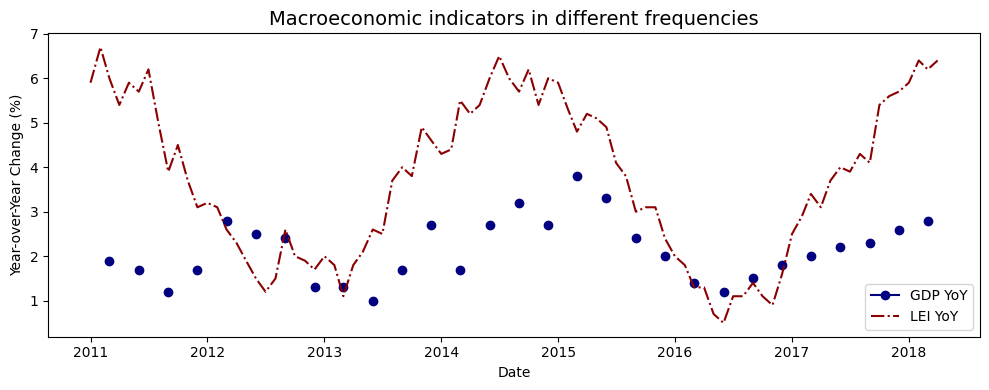

In [87]:
# Plot
plt.figure(figsize=(10, 4))
plt.plot(df_macro.index, df_macro['gdp_yoy'], label='GDP YoY', marker='o', linestyle='-', color='navy')
plt.plot(df_macro.index, df_macro['lei_yoy'], label='LEI YoY', linestyle='-.', color='darkred')

# Formatting
plt.title('Macroeconomic indicators in different frequencies', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Year-over-Year Change (%)')
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 🧠 MIDAS Model Specification

$$ y_t = c + \beta_1 \cdot \sum_{k=1}^{3} w_k(\theta_{11}, \theta_{12}) \cdot x_{t - \frac{k}{3}} + \lambda \cdot y_{t-1} + \varepsilon_t $$

Where:
+ 	$y_t$: low-frequency target (quarterly GDP YoY)
+ 	$x_{t - \frac{k}{3}}$: high-frequency regressor (LEI_YoY) at monthly lag k
+ 	$w_k(\theta_{11}, \theta_{12})$: exponential Almon weights over 3 monthly lags
+	$c$: intercept
+	$\beta_1$: coefficient on the weighted sum of high-frequency lags
+ 	$\lambda$: AR(1) coefficient
+	$\varepsilon_t$: error term

In [88]:
from MIDAS import MIDAS

midas_model = MIDAS(low_freq_series       = df_macro["gdp_yoy"],
                    high_freq_series_list = [df_macro["lei_yoy"]],
                    hf_lags_list          = ["3m"],
                    lf_lags               = 1)

+ If `GDP` is quarterly (e.g., March 2019), and `LEI` is monthly:
+ Then `3m` means you include the last 3 monthly values of `LEI` up to the end of the current quarter (i.e., Jan–Mar 2019).

**🧠 Case A: alignment_lag = 0 (`Nowcasting`)**

+ Y Data (Training):          → GDP for 2011-06-01 (Q2)
+ HF Data (Training):         → [LEI Jun, May, Apr] = [5.7, 5.9, 5.4]

**🧠 Case B: alignment_lag = 3 (`Forecasting`)**

+ Y Data (Training):          → GDP for 2011-09-01 (Q3)
+ HF Data (Training):         → [LEI Jun, May, Apr] = [5.7, 5.9, 5.4]

In [89]:
from datetime import datetime

# Prepare the data (optional, just to inspect the structure)
result = midas_model.prepare_data(alignment_lag = 0,
                                  start_date    = datetime(2011, 3, 1),
                                  end_date      = datetime(2014, 12, 1))

# Display results
print("Y Data (Training):\n",    result["y_train"].head())
print("\nY Lags (Training):\n",  result["y_train_lags"].head())
print("\nHF Data (Training):\n", result["x_train_list"][0].head())
print("\nY Data (Test):\n",      result["y_forecast_target"].head())
print("\nY Lags (Test):\n",      result["y_forecast_lags"].head())
print("\nHF Data (Test):\n",     result["x_forecast_list"][0].head())

Y Data (Training):
 DATE
2011-06-01    1.7
2011-09-01    1.2
2011-12-01    1.7
2012-03-01    2.8
2012-06-01    2.5
Name: gdp_yoy, dtype: float64

Y Lags (Training):
             gdp_yoy
DATE               
2011-06-01      1.9
2011-09-01      1.7
2011-12-01      1.2
2012-03-01      1.7
2012-06-01      2.8

HF Data (Training):
               0    1    2
DATE                     
2011-06-01  5.7  5.9  5.4
2011-09-01  3.9  5.0  6.2
2011-12-01  3.1  3.7  4.5
2012-03-01  2.6  3.1  3.2
2012-06-01  1.5  1.9  2.3

Y Data (Test):
 DATE
2014-12-01    2.7
2015-03-01    3.8
2015-06-01    3.3
2015-09-01    2.4
2015-12-01    2.0
Name: gdp_yoy, dtype: float64

Y Lags (Test):
             gdp_yoy
DATE               
2014-12-01      3.2
2015-03-01      2.7
2015-06-01      3.8
2015-09-01      3.3
2015-12-01      2.4

HF Data (Test):
               0    1    2
DATE                     
2014-12-01  6.0  5.4  6.2
2015-03-01  4.8  5.3  5.9
2015-06-01  4.9  5.1  5.2
2015-09-01  3.0  3.8  4.1
2015-12-01  2.4  

### 📐 Exponential Almon Weights:

$$ w_k(\theta_{11}, \theta_{12}) =
\frac{
\exp(\theta_{11} \cdot k + \theta_{12} \cdot k^2)
}{
\sum_{j=1}^{3} \exp(\theta_{11} \cdot j + \theta_{12} \cdot j^2)
}
\quad \text{for } k = 1, 2, 3 $$

### 🔧 Parameter Vector:

$$ \Phi = \begin{bmatrix}
c & \beta_1 & \theta_{11} & \theta_{12} & \lambda
\end{bmatrix}$$

In [90]:
# Fit the model
opt_res = midas_model.fit(data_dict = result, poly_list=["expalmon"])

# Extract fitted parameters
print(opt_res.x)

[  0.65544787   0.13578227  32.85228158 -10.20023396   0.43861476]


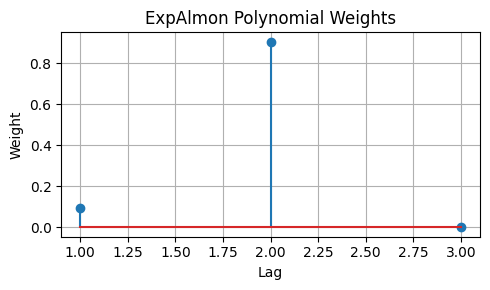

In [91]:
from MIDAS import ExpAlmonWeights

expalmon = ExpAlmonWeights()
theta_exp_almon = opt_res.x[2:4]  # assuming [theta1, theta2] are at positions 2 and 3
expalmon.theta = theta_exp_almon
nlags = 3  
weights = expalmon.weights(nlags)

# Plot
plt.figure(figsize=(5, 3))
plt.stem(range(1, nlags + 1), weights)
plt.title('ExpAlmon Polynomial Weights')
plt.xlabel('Lag')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
# Nowcast the low-frequency series
pred = midas_model.predict(data_dict = result)

# Join predictions
y_target_df = result["y_forecast_target"].to_frame(name="y_target")
forecast_df = y_target_df.join(pred)
forecast_df.columns = ['y_target', 'y_nowcast']
forecast_df

,y_target,y_nowcast
DATE,,
2014-12-01,2.7,2.799996
2015-03-01,3.8,2.552890
2015-06-01,3.3,3.012088
2015-09-01,2.4,2.608507
2015-12-01,2.0,2.119999
2016-03-01,1.4,1.770621
2016-06-01,1.2,1.361970
2016-09-01,1.5,1.335025
2016-12-01,1.8,1.444624


## Rolling forecast

In [93]:
df_rolling, rmse = midas_model.rolling_forecast(start_date = datetime(2011, 3, 1),
                                                end_date   = datetime(2014, 12, 1),
                                                alignment_lag = 0,
                                                poly_list = ["expalmon"],
                                                verbose = True)
df_rolling

Rolling window end = 2014-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2015-03-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2015-06-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2015-09-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2015-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2016-03-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2016-06-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2016-09-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2016-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-03-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-06-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-09-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2017-12-01 00:00:00 | Forecast horizon = 0
Rolling window end = 2018-03-01 00:00:00 | Forecast horizon = 0

✅ Final RMSE: 0.3339


,preds,targets
2014-12-01,2.799996,2.7
2015-03-01,2.760484,3.8
2015-06-01,3.317768,3.3
2015-09-01,2.749738,2.4
2015-12-01,2.163956,2.0
2016-03-01,1.684551,1.4
2016-06-01,1.178751,1.2
2016-09-01,1.219973,1.5
2016-12-01,1.421304,1.8
2017-03-01,1.901559,2.0


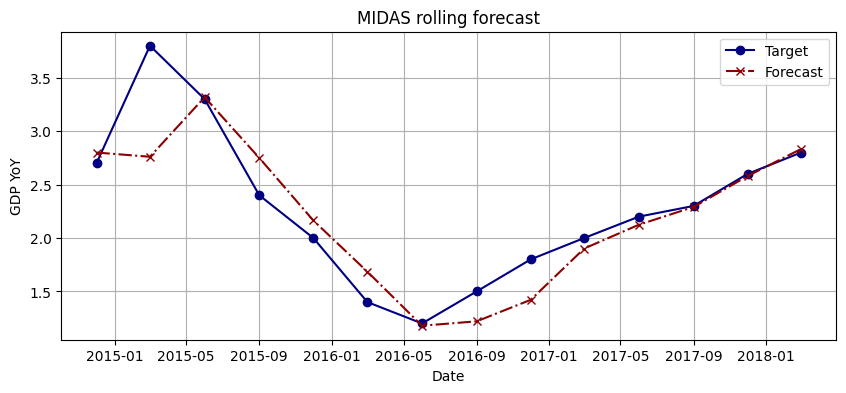

In [94]:
# Plot the predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(df_rolling.index, df_rolling["targets"], label="Target", color='navy', marker='o')
plt.plot(df_rolling.index, df_rolling["preds"], label="Forecast", color='darkred', marker='x', linestyle='-.')
plt.title("MIDAS rolling forecast")
plt.xlabel("Date")
plt.ylabel("GDP YoY")
plt.legend()
plt.grid()
plt.show()

## Model comparison

In [95]:
from MIDAS import MIDAS

mod1 = MIDAS(low_freq_series       = df_macro["gdp_yoy"],
             high_freq_series_list = [df_macro["ip_yoy"], df_macro["lei_yoy"]],
             hf_lags_list          = ["3m", "3m"], 
             lf_lags               = 1)

df1, rmse1 = mod1.rolling_forecast(start_date = datetime(2011, 3, 1),
                                   end_date   = datetime(2014, 12, 1),
                                   alignment_lag = 0,
                                   poly_list = ["expalmon", "expalmon"],
                                   verbose = False)

In [96]:
mod2 = MIDAS(low_freq_series       = df_macro["gdp_yoy"],
             high_freq_series_list = [df_macro["lei_yoy"]],
             hf_lags_list          = ["3m"], 
             lf_lags               = 1)

df2, rmse2 = mod2.rolling_forecast(start_date = datetime(2011, 3, 1),
                                   end_date   = datetime(2014, 12, 1),
                                   alignment_lag = 0,
                                   poly_list = ["expalmon"],
                                   verbose = False)

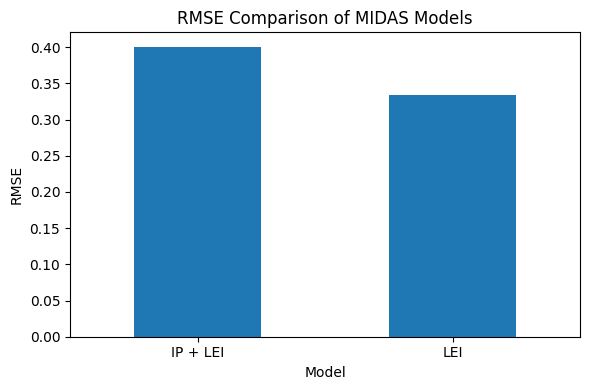

In [97]:
# Compare RMSE values
rmse_df = pd.DataFrame({
    'Model': ['IP + LEI', 'LEI'],
    'RMSE': [rmse1, rmse2]
})
rmse_df.set_index('Model', inplace=True)
rmse_df.plot(kind='bar', figsize=(6, 4), legend=False)
plt.title('RMSE Comparison of MIDAS Models')
plt.ylabel('RMSE')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## The `midas_compare` function

Fitting model: IP
Fitting model: LEI
Fitting model: IP + LEI


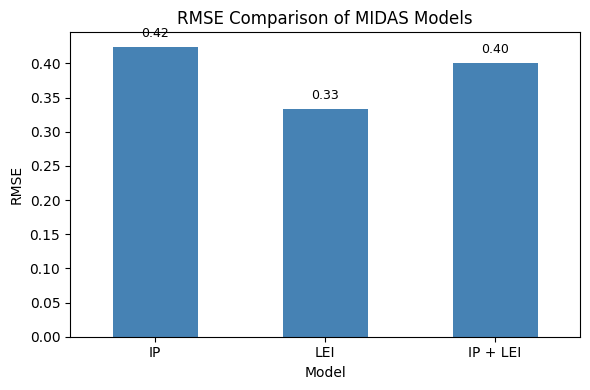

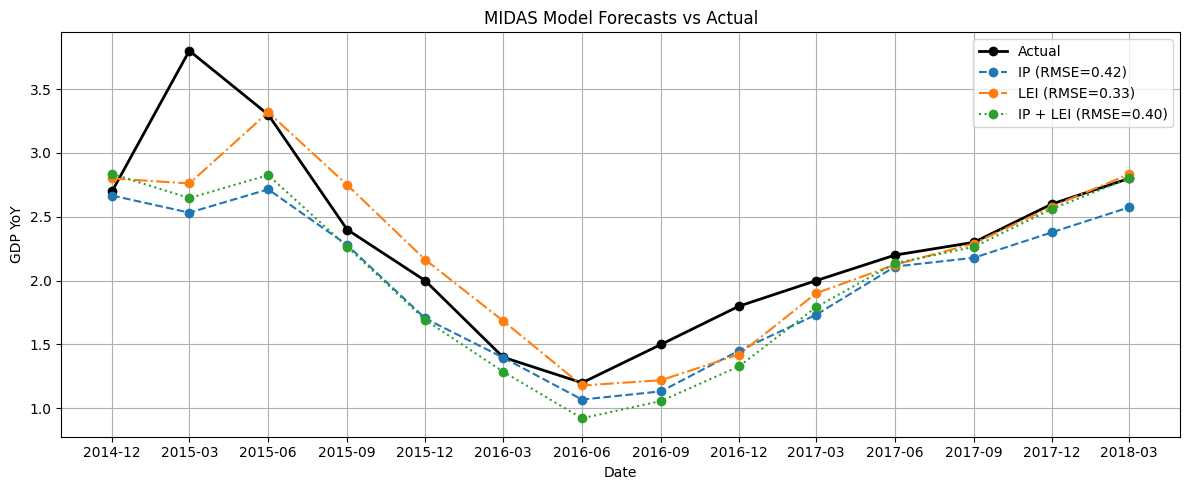

In [98]:
from MIDAS import midas_compare

models = [
    {"name": "IP", "high_freq_series": [df_macro["ip_yoy"]], "polys": ["expalmon"]},
    {"name": "LEI", "high_freq_series": [df_macro["lei_yoy"]], "polys": ["expalmon"]},
    {"name": "IP + LEI", "high_freq_series": [df_macro["ip_yoy"], df_macro["lei_yoy"]], "polys": ["expalmon", "expalmon"]}
]

results = midas_compare(
    low_freq_series=df_macro["gdp_yoy"],
    model_specs=models,
    hf_lags=["3m", "3m"],  
    lf_lags=1,
    alignment_lag=0,
    start_date=datetime(2011, 3, 1),
    end_date=datetime(2014, 12, 1),
    plot_forecasts=True
)